## Learning a random vector.

Here we train a simple fully connected network of some number of layers to learn a completely random vector over some number of classes.
Below we train the network to categorize each of 4,096 possible inputs (encoded as a bitstring) into one of four possible categories.
Our network architecture consists of some number of layers of linearity-then-ReLU with numbers of dimensions in each layer specified in the `architecture` variable below.

The goal is to see how well the network can learn the random input as a function of its model capacity.

In [1]:
import random, math
import numpy as np
import tensorflow as tf

In [2]:
# Choose the bit-length of the input to the network.
# This is the number of input dimensions, and 2**bitlength is the number of cases the network has to memorize.
bitlength = 12

# Choose the number of possible classes there are for each input to be binned into.
# Ths is the number of output dimensions.
classes = 4

# Choose the number of parameters in each layer, and how many layers our model has.
architecture = [bitlength, 64, 64, 32, classes]

print "Total bits of entropy to memorize:", 2**bitlength * math.log(classes, 2)

Total bits of entropy to memorize: 8192.0


In [3]:
# Generate each one-hot vector, [1, 0, ...], [0, 1, ...], ...
one_hots = [np.array([int(i == j) for j in xrange(classes)]) for i in xrange(classes)]

# Generate all 2^bitlength possible bitstring vectors.
xs = [np.array([(n >> i) & 1 for i in xrange(bitlength)]) for n in xrange(2**bitlength)]

# Choose a random one-hot vector for each possible input. This is our random function to learn.
ys = [random.choice(one_hots) for i in xrange(2**bitlength)]

In [5]:
total_model_parameters = 0
prod = lambda shape: reduce(lambda x, y: x * y, shape)

def weight_variable(shape):
    global total_model_parameters
    total_model_parameters += prod(shape)
    stddev = (2.0 / prod(shape[:-1]))**0.5
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))

def bias_variable(shape):
    global total_model_parameters
    total_model_parameters += prod(shape)
    return tf.Variable(tf.constant(0.1, shape=shape))

input_ph  = tf.placeholder(tf.float32, shape=[None, bitlength], name="input_ph")
output_ph = tf.placeholder(tf.float32, shape=[None, classes], name="output_ph")
state = input_ph
for i, (old, new) in enumerate(zip(architecture, architecture[1:])):
    W = weight_variable([old, new])
    b = bias_variable([new])
    print "Linear layer: %i -> %i" % (old, new)
    state = tf.matmul(state, W) + b
    # In all but the last layer do non-linearity.
    if i < len(architecture) - 2:
        print "ReLU non-linearity."
        state = tf.nn.relu(state)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=output_ph,
    logits=state,
))
learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
train_step = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(cross_entropy)
accuracy = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(state, 1), tf.argmax(output_ph, 1)),
    tf.float32,
))
# Set the initial learning rate and minibatch size.
lr = 0.05
minibatch_size = 128

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
print "Total model parameters:", total_model_parameters

Linear layer: 12 -> 64
ReLU non-linearity.
Linear layer: 64 -> 64
ReLU non-linearity.
Linear layer: 64 -> 32
ReLU non-linearity.
Linear layer: 32 -> 4
Total model parameters: 7204


In [6]:
def run(f, x, y):
    return f(feed_dict={
        input_ph: x,
        output_ph: y,
        learning_rate: lr,
    })

loss_plot = []
accuracy_plot = []
best_loss_so_far = float("inf")
total_batches = 0
for epoch in xrange(1000):
    # Evaluate the loss.
    loss = run(cross_entropy.eval, xs, ys)
    acc  = run(accuracy.eval, xs, ys)
    loss_plot.append(loss)
    accuracy_plot.append(acc)
    if total_batches % 1000 == 0:
        print "Batches: %5i  Loss: %8.6f  Accuracy: %7.3f%%  lr = %.6f" % (total_batches, loss, 100 * acc, lr)
    # Implement a learning rate schedule.
    if loss >= best_loss_so_far:
        lr *= 0.998
    best_loss_so_far = min(best_loss_so_far, loss)
    # Stop executing if we're either done, or probably can't make any further progress.
    if acc >= 1.0 or lr < 1e-5:
        print "Done training."
        break
    # Do some steps.
    for step in xrange(20):
        batch_indices = random.sample(xrange(2**bitlength), minibatch_size)
        inputs  = [xs[i] for i in batch_indices]
        outputs = [ys[i] for i in batch_indices]
        # Do a training step.
        run(train_step.run, inputs, outputs)
        total_batches += 1

Batches:     0  Loss: 1.598050  Accuracy:  26.074%  lr = 0.050000
Batches:  1000  Loss: 1.241138  Accuracy:  42.993%  lr = 0.048618
Batches:  2000  Loss: 0.975282  Accuracy:  59.106%  lr = 0.046152
Batches:  3000  Loss: 0.723648  Accuracy:  70.850%  lr = 0.043202
Batches:  4000  Loss: 0.550412  Accuracy:  78.345%  lr = 0.040117
Batches:  5000  Loss: 0.370409  Accuracy:  85.669%  lr = 0.037104
Batches:  6000  Loss: 0.264545  Accuracy:  89.966%  lr = 0.034180
Batches:  7000  Loss: 0.186842  Accuracy:  93.286%  lr = 0.031424
Batches:  8000  Loss: 0.106592  Accuracy:  96.631%  lr = 0.028716
Batches:  9000  Loss: 0.014635  Accuracy:  99.756%  lr = 0.027097
Batches: 10000  Loss: 0.008257  Accuracy:  99.878%  lr = 0.026085
Batches: 11000  Loss: 0.005889  Accuracy:  99.927%  lr = 0.024961
Batches: 12000  Loss: 0.004543  Accuracy:  99.927%  lr = 0.024174
Batches: 13000  Loss: 0.004033  Accuracy:  99.927%  lr = 0.023272
Batches: 14000  Loss: 0.003629  Accuracy:  99.927%  lr = 0.022674
Batches: 1

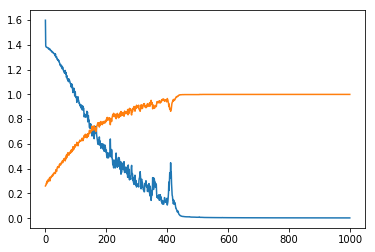

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = plt.plot(loss_plot)
_ = plt.plot(accuracy_plot)